# Mapping the largest Holocene Volcanic Eruptions (take 2)

This notebook is an update of my dated blog post (https://scottyhq.github.io/blog/2014/02/08/mapping-volcanic-eruptions/) illustrating some great new tools

The goal is to generate a map of major Holocene volcanic eruptions. Data is from the Smithsonian Global Volcanism Program. Recently the website was updated with improved search tools and the ability to download database search results to .csv format. We will search the eruptions database for volcano explosivity index (VEI) greater than 4. This index is a measure of the magnitude of an explosive volcanic eruption, and can be converted to erupted volume on a logarithmic scale.

Note that Smithsonian has released some great tools recently, including a GeoServer to query data programmatically:
http://volcano.si.edu/database/webservices.cfm. Previously, you had to manually search and download excel files, so this change is great for us programmers!

In [1]:
# We will use the following excellent Python Packages
import matplotlib.pyplot as plt 
import owslib 
from owslib.wfs import WebFeatureService
import cartopy
import cartopy.crs as ccrs
import shapely
from shapely import wkt 
import pandas as pd 
import geopandas as gpd 
from io import StringIO 
%matplotlib inline
#%qtconsole #helpful for interaction

## GeoServer WFS interaction with owslib and pandas

In [2]:
# Connect to Smithsonian Geoserver, list contents
wfs = WebFeatureService(url='https://webservices.volcano.si.edu/geoserver/GVP-VOTW/wfs', version='1.1.0')
list(wfs.contents)

['GVP-VOTW:E3WebApp_EmissionPixels',
 'GVP-VOTW:E3WebApp_Emissions',
 'GVP-VOTW:E3WebApp_Eruptions1960',
 'GVP-VOTW:E3WebApp_HoloceneVolcanoes',
 'GVP-VOTW:GVP_Placemarks',
 'GVP-VOTW:Smithsonian VOTW Holocene Volcanoes',
 'GVP-VOTW:sivolcanodata',
 'GVP-VOTW:VOTW_Holocene_Volcanoes',
 'GVP-VOTW:VOTW_Holocene_Eruptions (test)',
 'GVP-VOTW:VOTW_Pleistocene_Volcanoes']

In [3]:
# How many Holocene volcanoes are in the VOTW?
# Read entire volcano list directly from server
typename = 'GVP-VOTW:VOTW_Holocene_Volcanoes'
output = 'csv'
response = wfs.getfeature(typename=typename, outputFormat=output)
dfV = pd.read_csv(StringIO(response.read()))
print('# Holocene Volcanoes=', len(dfV))


# NOTE: it's a good idea to save the file we use in case changes occur to the dataset on the server:
typename = 'GVP-VOTW:VOTW_Holocene_Volcanoes'
output = 'csv'
csvname = 'votw.csv'
response = wfs.getfeature(typename=typename, outputFormat=output)
with open(csvname, 'w') as out:
    out.write(response.read())
    
dfV = pd.read_csv(csvname)
print('# Holocene Volcanoes=', len(dfV))

# Holocene Volcanoes= 1439
# Holocene Volcanoes= 1439


In [4]:
# Query server by bounding box for particular region
# (left, bottom, right, top) in the feature type's coordinates == (minx, miny, maxx, maxy)
typename = 'GVP-VOTW:VOTW_Holocene_Volcanoes'
bbox = (-80, 0, -75, 6)
output = 'csv'
response = wfs.getfeature(typename=typename, bbox=bbox, outputFormat=output)
df = pd.read_csv(StringIO(response.read()))

In [5]:
# Take a quick look at the first entries
print('Entries= ', len(df))
df = pd.read_csv(csvname)
df.head()

Entries=  22


,FID,Volcano_Number,Volcano_Name,Primary_Volcano_Type,Last_Eruption_Year,Country,Geological_Summary,Region,Subregion,Latitude,Longitude,Elevation,Tectonic_Setting,Geologic_Epoch,Evidence_Category,Primary_Photo_Link,Primary_Photo_Caption,Primary_Photo_Credit,Major_Rock_Type,GeoLocation
0,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,210010,West Eifel Volcanic Field,Maar(s),-8300.0,Germany,The West Eifel volcanic field in the Rhineland...,Mediterranean and Western Asia,Western Europe,50.170,6.85,600,Rift zone / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/015001.jpg,The lake-filled Weinfelder maar is one of abou...,"Photo by Richard Waitt, 1990 (U.S. Geological ...",Foidite,POINT (50.17 6.85)
1,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,210020,Chaine des Puys,Lava dome(s),-4040.0,France,"The Chaîne des Puys, prominent in the history ...",Mediterranean and Western Asia,Western Europe,45.775,2.97,1464,Rift zone / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/088002.jpg,The central part of the Chaîne des Puys volcan...,Photo by Ichio Moriya (Kanazawa University).,Basalt / Picro-Basalt,POINT (45.775 2.97)
2,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,210030,Olot Volcanic Field,Pyroclastic cone(s),NaN,Spain,The Olot volcanic field (also known as the Gar...,Mediterranean and Western Asia,Western Europe,42.170,2.53,893,Intraplate / Continental crust (> 25 km),Holocene,Evidence Credible,http://volcano.si.edu/photos/full/119091.jpg,The forested Volcà Montolivet cinder cone rise...,Photo by Puigalder (Wikimedia Commons).,Trachybasalt / Tephrite Basanite,POINT (42.17 2.53)
3,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,210040,Calatrava Volcanic Field,Pyroclastic cone(s),-3600.0,Spain,The Calatrava volcanic field lies in central S...,Mediterranean and Western Asia,Western Europe,38.870,-4.02,1117,Intraplate / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/118054.jpg,"Columba volcano, the youngest dated vent of th...","Photo by Rafael Becerra Ramírez, 2006 (Univers...",Basalt / Picro-Basalt,POINT (38.87 -4.02)
4,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,211001,Larderello,Explosion crater(s),1282.0,Italy,"Larderello, one of the world's most productive...",Mediterranean and Western Asia,Italy,43.250,10.87,500,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Observed,http://volcano.si.edu/photos/full/094048.jpg,"Steam pours from cooling towers at Larderello,...","Photo by Giuseppina Kysar, 1985 (Smithsonian I...",No Data (checked),POINT (43.25 10.87)


In [6]:
# Instead of filtering by bounding box, use a filter:
query = owslib.fes.PropertyIsEqualTo(propertyname='Subregion', literal='Colombia', matchcase=True)
querystr = owslib.etree.etree.tostring(query.toXML()).decode("utf-8")

response = wfs.getfeature(typename=typename, outputFormat=output, filter=querystr)
df = pd.read_csv(StringIO(response.read()))

In [7]:
print('Entries= ', len(df))
df = pd.read_csv(csvname)
df.head()

Entries=  15


,FID,Volcano_Number,Volcano_Name,Primary_Volcano_Type,Last_Eruption_Year,Country,Geological_Summary,Region,Subregion,Latitude,Longitude,Elevation,Tectonic_Setting,Geologic_Epoch,Evidence_Category,Primary_Photo_Link,Primary_Photo_Caption,Primary_Photo_Credit,Major_Rock_Type,GeoLocation
0,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,210010,West Eifel Volcanic Field,Maar(s),-8300.0,Germany,The West Eifel volcanic field in the Rhineland...,Mediterranean and Western Asia,Western Europe,50.170,6.85,600,Rift zone / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/015001.jpg,The lake-filled Weinfelder maar is one of abou...,"Photo by Richard Waitt, 1990 (U.S. Geological ...",Foidite,POINT (50.17 6.85)
1,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,210020,Chaine des Puys,Lava dome(s),-4040.0,France,"The Chaîne des Puys, prominent in the history ...",Mediterranean and Western Asia,Western Europe,45.775,2.97,1464,Rift zone / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/088002.jpg,The central part of the Chaîne des Puys volcan...,Photo by Ichio Moriya (Kanazawa University).,Basalt / Picro-Basalt,POINT (45.775 2.97)
2,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,210030,Olot Volcanic Field,Pyroclastic cone(s),NaN,Spain,The Olot volcanic field (also known as the Gar...,Mediterranean and Western Asia,Western Europe,42.170,2.53,893,Intraplate / Continental crust (> 25 km),Holocene,Evidence Credible,http://volcano.si.edu/photos/full/119091.jpg,The forested Volcà Montolivet cinder cone rise...,Photo by Puigalder (Wikimedia Commons).,Trachybasalt / Tephrite Basanite,POINT (42.17 2.53)
3,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,210040,Calatrava Volcanic Field,Pyroclastic cone(s),-3600.0,Spain,The Calatrava volcanic field lies in central S...,Mediterranean and Western Asia,Western Europe,38.870,-4.02,1117,Intraplate / Continental crust (> 25 km),Holocene,Eruption Dated,http://volcano.si.edu/photos/full/118054.jpg,"Columba volcano, the youngest dated vent of th...","Photo by Rafael Becerra Ramírez, 2006 (Univers...",Basalt / Picro-Basalt,POINT (38.87 -4.02)
4,VOTW_Holocene_Volcanoes.fid--4d9842f7_162e410d...,211001,Larderello,Explosion crater(s),1282.0,Italy,"Larderello, one of the world's most productive...",Mediterranean and Western Asia,Italy,43.250,10.87,500,Subduction zone / Continental crust (> 25 km),Holocene,Eruption Observed,http://volcano.si.edu/photos/full/094048.jpg,"Steam pours from cooling towers at Larderello,...","Photo by Giuseppina Kysar, 1985 (Smithsonian I...",No Data (checked),POINT (43.25 10.87)


In [8]:
# Load the eruptions database (full size is ~40Mb, so filtering helps reduce file size!)
# Get Global Eruptions with VEI>4

query = owslib.fes.PropertyIsGreaterThanOrEqualTo(propertyname='ExplosivityIndexMax', literal='4')
querystr = owslib.etree.etree.tostring(query.toXML()).decode("utf-8")

typename = 'GVP-VOTW:VOTW_Holocene_Eruptions (test)'
output = 'csv'
response = wfs.getfeature(typename=typename, outputFormat=output, filter=querystr)
# Again, save this one in case we want to revist the analysis
csvname = 'votw-eruptions.csv'
with open(csvname, 'w') as out:
    out.write(response.read())
    
df = pd.read_csv(csvname)

In [9]:
print('Entries= ', len(df))
df.head()
print(df.keys())

Entries=  741
Index(['FID', 'Volcano_Number', 'Volcano_Name', 'Eruption_Number',
       'Activity_Type', 'ExplosivityIndexMax', 'ExplosivityIndexModifier',
       'ActivityArea', 'ActivityUnit', 'StartEvidenceMethod',
       'StartDateYearModifier', 'StartDateYear', 'StartDateYearUncertainty',
       'StartDateDayModifier', 'StartDateMonth', 'StartDateDay',
       'StartDateDayUncertainty', 'EndDateYearModifier', 'EndDateYear',
       'EndDateYearUncertainty', 'EndDateDayModifier', 'EndDateMonth',
       'EndDateDay', 'EndDateDayUncertainty', 'GeoLocation'],
      dtype='object')


In [10]:
print('There are {0} recorded eruptions in this database'.format(len(df)))
print('The eruptions have occured at {0} volcanos'.format(df.Volcano_Name.unique().size))

There are 741 recorded eruptions in this database
The eruptions have occured at 259 volcanos


In [11]:
df.head()

,FID,Volcano_Number,Volcano_Name,Eruption_Number,Activity_Type,ExplosivityIndexMax,ExplosivityIndexModifier,ActivityArea,ActivityUnit,StartEvidenceMethod,...,StartDateDay,StartDateDayUncertainty,EndDateYearModifier,EndDateYear,EndDateYearUncertainty,EndDateDayModifier,EndDateMonth,EndDateDay,EndDateDayUncertainty,GeoLocation
0,VOTW_Holocene_Eruptions (test).fid--4d9842f7_1...,211010,Campi Flegrei,10018,Confirmed Eruption,4,NaN,NaN,Agnano Pomici Principali tephra,Radiocarbon (corrected),...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (40.827 14.139)
1,VOTW_Holocene_Eruptions (test).fid--4d9842f7_1...,211010,Campi Flegrei,10021,Confirmed Eruption,4,NaN,"Fondi di Baia, Sartania",NaN,Radiocarbon (uncorrected),...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (40.827 14.139)
2,VOTW_Holocene_Eruptions (test).fid--4d9842f7_1...,211010,Campi Flegrei,10026,Confirmed Eruption,4,NaN,Cigliano,NaN,Tephrochronology,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (40.827 14.139)
3,VOTW_Holocene_Eruptions (test).fid--4d9842f7_1...,211010,Campi Flegrei,10033,Confirmed Eruption,5,NaN,Agnano Monte Spina,NaN,Radiocarbon (uncorrected),...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (40.827 14.139)
4,VOTW_Holocene_Eruptions (test).fid--4d9842f7_1...,211010,Campi Flegrei,10036,Confirmed Eruption,4,NaN,Averno,NaN,Tephrochronology,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,POINT (40.827 14.139)


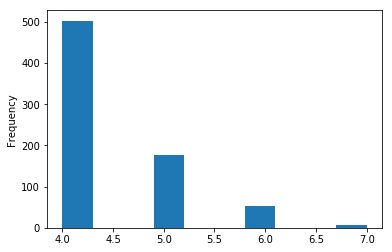

In [12]:
# Histogram binned by eruption size
# Default plots are super easy but not so pretty
df.ExplosivityIndexMax.plot.hist()

Text(0.5,0,'VEI')

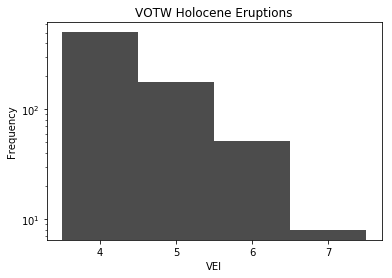

In [13]:
df.ExplosivityIndexMax.plot(kind='hist',
                            bins=[4,5,6,7,8], 
                            xticks=[4,5,6,7], 
                            color='k',
                            title='VOTW Holocene Eruptions',
                            alpha=0.7,
                            align='left',
                           )
plt.yscale('log')
plt.xlabel('VEI')

## Plot on a map with cartopy

In [14]:
# Databases often have some strange lines and manual cleanup is necessary, in this case, there is a missing location point
#df[df.GeoLocation.isna()]
df = df.dropna(subset=['GeoLocation'])
# Also, the VOTW has points in (lat,lon) instead of the more common (lon, lat)
points = df.GeoLocation.apply(wkt.loads)
df['Longitude'] = points.apply(lambda p: p.y)
df['Latitude'] = points.apply(lambda p: p.x)

Text(0.5,1,'740 VOTW Eruptions (VEI>4)')

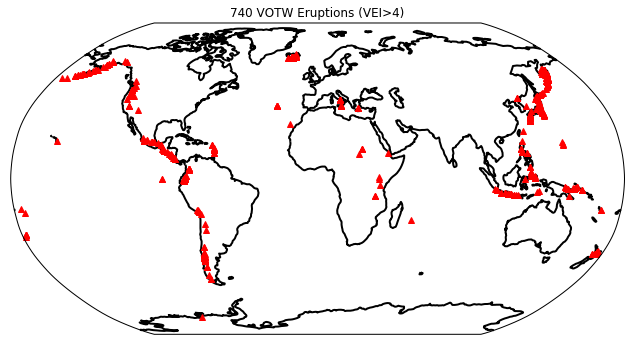

In [15]:
# Plot on a map with the excellent cartopy library
plt.figure(figsize=(11, 8.5))
ax = plt.axes(projection=ccrs.Robinson())
ax.set_global()
#ax.stock_img()  # Add background image (slow)
ax.coastlines(resolution='110m', lw=2)
plt.plot(df.Longitude, df.Latitude, 'r^', color='red', transform=ccrs.Geodetic(), label='GVP Volcanoes')
#plt.legend()
plt.title('{} VOTW Eruptions (VEI>4)'.format(df.shape[0]))

## Geopandas for geospatial tabular data

In [16]:
# Create a Geopandas Geodataframe
geometry = df.apply(lambda x: shapely.geometry.Point(x['Longitude'],x['Latitude']), axis = 1)
crs={'init': 'epsg:4326'}
gf = gpd.GeoDataFrame(df, geometry=geometry, crs=crs)

In [17]:
# First entry
gf.iloc[0]

FID                         VOTW_Holocene_Eruptions (test).fid--4d9842f7_1...
Volcano_Number                                                         211010
Volcano_Name                                                    Campi Flegrei
Eruption_Number                                                         10018
Activity_Type                                              Confirmed Eruption
ExplosivityIndexMax                                                         4
ExplosivityIndexModifier                                                  NaN
ActivityArea                                                              NaN
ActivityUnit                                  Agnano Pomici Principali tephra
StartEvidenceMethod                                   Radiocarbon (corrected)
StartDateYearModifier                                                     NaN
StartDateYear                                                           -8480
StartDateYearUncertainty                                        

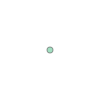

In [18]:
# This geopandas dataframe looks the same, but knows how to work with geospatial vector data:
gf.geometry.iloc[0]

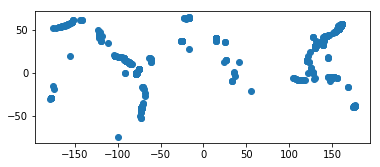

In [19]:
# So plotting is really easy
gf.geometry.plot()

In [20]:
# What if you want to quickly look at eruptions in South America?
# Note that the eruptions database and volcano database have different columns, but common volcano number ids
# So you can query one database and select entries in the other very easily:
# A few quick examples:

# 1) Look at all eruptions of Cerro Hudson
name = 'Hudson, Cerro'
vid = dfV.query("Volcano_Name == @name").Volcano_Number.values[0]
print(vid)
hudson = gf.query('Volcano_Number == @vid')
n = len(hudson)
print(f'{n} eruptions at {name}')

# 2) Look at all eruptions in South America
vid = dfV.query("Region == 'South America'").Volcano_Number.values
subset = gf[gf.Volcano_Number.isin(vid)]
subset
print(subset.Volcano_Name.unique())

358057
3 eruptions at Hudson, Cerro
['Romeral' 'Bravo, Cerro' 'Ruiz, Nevado del' 'Tolima, Nevado del'
 'Dona Juana' 'Azufral' 'Soche' 'Cuicocha' 'Cayambe' 'Pululagua'
 'Reventador' 'Atacazo' 'Guagua Pichincha' 'Cotopaxi' 'Quilotoa'
 'Tungurahua' 'Fernandina' 'Wolf' 'Misti, El' 'Ubinas' 'Huaynaputina'
 'Tutupaca' 'Yucamane' 'Parinacota' 'Lascar' 'Blanco, Cerro'
 'Planchon-Peteroa' 'Azul, Cerro' 'Sollipulli' 'Llaima' 'Villarrica'
 'Carrán-Los Venados' 'Antillanca Group' 'Puyehue-Cordon Caulle' 'Osorno'
 'Hornopiren' 'Apagado' 'Calbuco' 'Chaiten' 'Michinmahuida'
 'Hudson, Cerro' 'Aguilera' 'Burney, Monte']


In [21]:
# Save as geojson, which is automatically rendered on github!
# NOTE: commented to not overwrite existing file
#gf.to_file('votw-vei4.geojson', driver='GeoJSON')
print('Check out the awesome free interactive visualization this gives you!')
print('https://github.com/scottyhq/votw/blob/master/votw-vei4.geojson')

Check out the awesome free interactive visualization this gives you!
https://github.com/scottyhq/votw/blob/master/votw-vei4.geojson


## This is just scratching the surface of what you can do with these tools! 